#IMPORTS 🔬

Dataset link - http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
DATA_DIR = '/content/drive/MyDrive/CamVid/'
os.listdir(DATA_DIR)

['test.txt',
 'train.txt',
 'val.txt',
 'valannot',
 'val',
 'trainannot',
 'testannot',
 'train',
 'test']

In [3]:
x_train_dir = os.path.join(DATA_DIR + 'train')
y_train_dir = os.path.join(DATA_DIR + 'trainannot')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'valannot')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'testannot')

In [4]:
def visualize(**images):
  n = len(images)
  plt.figure(figsize = (10,10))
  for i, (name, image) in enumerate(images.items()):
    plt.subplot(1, n, i + 1)
    plt.title(' '.join(name.split('_')).title())
    plt.imshow(image)
  plt.show()

# DATALOADER 🖨️

In [5]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

In [6]:
class DataSet(Dataset):

  CLASSES = ['sky', 'building', 'pole', 'road', 'pavement', 
               'tree', 'signsymbol', 'fence', 'car', 
               'pedestrian', 'bicyclist', 'unlabelled']

  def __init__(self, images_dir, masks_dir, classes = None, augmentation = None, preprocessing = None):
    self.ids = os.listdir(images_dir)
    self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
    self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]

    self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes] #holds the class values

    self.augmentation = augmentation
    self.preprocessing = preprocessing

  def __getitem__(self, index):
    image = cv2.imread(self.images_fps[index])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(self.masks_fps[index], 0) #the 0 flag tells it to load in grayscale

    masks = [(mask == classs) for classs in self.class_values] #extracting certain classes 
    mask = np.stack(masks, axis = -1).astype('float') #adding the third dimension back (360, 480, 1)

    if self.augmentation:
      sample = self.augmentation(image = image, mask = mask)
      image, mask = sample['image'], sample['mask']
    
    if self.preprocessing:
      sample = self.preprocessing(image = image, mask = mask)
      image, mask = sample['image'], sample['mask']
    
    return image, mask
  
  def __len__(self):
    return len(self.ids)

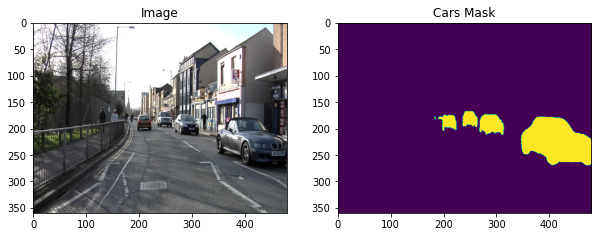

In [7]:
dataset = DataSet(images_dir = x_train_dir, masks_dir = y_train_dir, classes=['car'])

image, mask = dataset[0]
visualize(
    image = image, 
    cars_mask = mask.squeeze(),
)

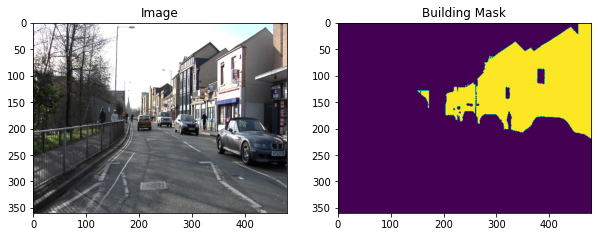

In [8]:
dataset = DataSet(images_dir = x_train_dir, masks_dir = y_train_dir, classes=['building'])

image, mask = dataset[0]
visualize(
    image = image, 
    building_mask = mask.squeeze(),
)

# AUGMENTATIONS 💫

In [9]:
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir &> /dev/null #not compactible with Lambda

In [10]:
! pip install albumentations==0.4.6

  Using cached albumentations-0.4.6-py3-none-any.whl
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.0.3
    Uninstalling albumentations-1.0.3:
      Successfully uninstalled albumentations-1.0.3


In [11]:
import albumentations as albu

In [12]:
def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        albu.RandomCrop(height=320, width=320, always_apply=True),

        albu.IAAAdditiveGaussianNoise(p=0.2),
        #albu.IAAPerspective(p=0.5), throws an error Exception: Expected number, tuple of two number, list of number or StochasticParameter for cval, got <class 'bool'>.

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)

In [13]:
def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(384, 480)
    ]
    return albu.Compose(test_transform)

In [14]:
def to_tensor(x, **kwargs):
  return x.transpose(2, 0 , 1).astype('float32')

In [15]:
def get_preprocessing(preprocessing_fn):
  _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
  return albu.Compose(_transform)

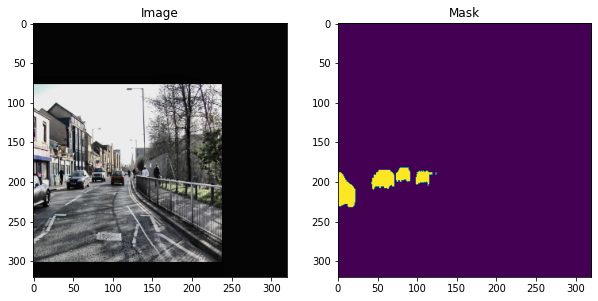

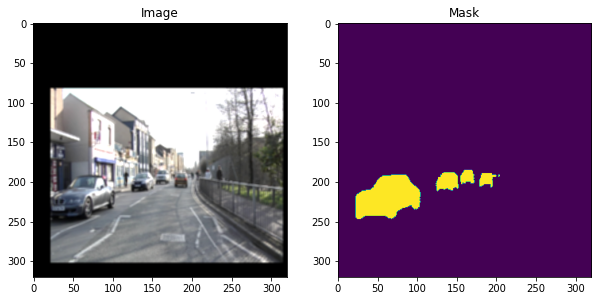

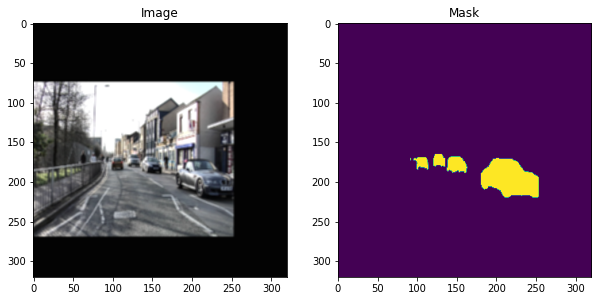

In [16]:
augmented_dataset = DataSet(x_train_dir, y_train_dir, augmentation = get_training_augmentation(), classes = ['car'])

for i in range(3):
  image, mask = augmented_dataset[0]
  visualize(image = image, mask = mask.squeeze(-1))

# MODEL TRAINING 💪

In [17]:
!pip install segmentation_models_pytorch

In [18]:
import torch
import numpy as np
import segmentation_models_pytorch as smp

In [19]:
ENCODER = 'resnet18'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['car']
ACTIVATION = 'sigmoid'
DEVICE = 'cuda'

model = smp.FPN(
    encoder_name = ENCODER,
    encoder_weights = ENCODER_WEIGHTS,
    classes = len(CLASSES),
    activation = ACTIVATION
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [20]:
train_dataset = DataSet(x_train_dir,
                        y_train_dir, 
                        augmentation = get_training_augmentation(), 
                        preprocessing = get_preprocessing(preprocessing_fn),
                        classes = CLASSES,
                        )

valid_dataset = DataSet(x_valid_dir,
                        y_valid_dir, 
                        augmentation = get_validation_augmentation(), 
                        preprocessing = get_preprocessing(preprocessing_fn),
                        classes = CLASSES,
                        )

train_loader = DataLoader(train_dataset, batch_size = 8, num_workers = 12, shuffle = True)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [21]:
loss = smp.utils.losses.DiceLoss()
metrics = [
           smp.utils.metrics.IoU(threshold = 0.5),
]
optimizer = torch.optim.Adam([
                             dict(params = model.parameters(), lr = 0.0001)
])

In [22]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss = loss, 
    metrics = metrics, 
    optimizer = optimizer,
    device = DEVICE,
    verbose = True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss = loss, 
    metrics = metrics, 
    device = DEVICE,
    verbose = True,
)

In [23]:
max_score = 0

for i in range(0, 40):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
train:   0%|          | 0/46 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


valid:   0%|          | 0/101 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


valid: 100%|██████████| 101/101 [00:30<00:00,  3.29it/s, dice_loss - 0.5598, iou_score - 0.3562]
Model saved!

Epoch: 1
valid: 100%|██████████| 101/101 [00:02<00:00, 35.93it/s, dice_loss - 0.5136, iou_score - 0.3627]
Model saved!

Epoch: 2
valid: 100%|██████████| 101/101 [00:02<00:00, 36.56it/s, dice_loss - 0.4319, iou_score - 0.4334]
Model saved!

Epoch: 3
valid: 100%|██████████| 101/101 [00:02<00:00, 37.88it/s, dice_loss - 0.3579, iou_score - 0.5276]
Model saved!

Epoch: 4
valid: 100%|██████████| 101/101 [00:02<00:00, 37.50it/s, dice_loss - 0.3327, iou_score - 0.544]
Model saved!

Epoch: 5
valid: 100%|██████████| 101/101 [00:02<00:00, 35.34it/s, dice_loss - 0.2865, iou_score - 0.6212]
Model saved!

Epoch: 6
valid: 100%|██████████| 101/101 [00:02<00:00, 34.98it/s, dice_loss - 0.4755, iou_score - 0.4403]

Epoch: 7
valid: 100%|██████████| 101/101 [00:02<00:00, 35.74it/s, dice_loss - 0.2499, iou_score - 0.6501]
Model saved!

Epoch: 8
valid: 100%|██████████| 101/101 [00:02<00:00, 34.50it/

# TESTING 🧪

In [24]:
best_model = torch.load('./best_model.pth')

In [27]:
test_dataset = DataSet(
    x_test_dir, 
    y_test_dir, 
    augmentation = get_validation_augmentation(), 
    preprocessing = get_preprocessing(preprocessing_fn),
    classes = CLASSES,
)

test_dataloader = DataLoader(test_dataset)

In [28]:
test_epoch = smp.utils.train.ValidEpoch(
    model = best_model,
    loss = loss,
    metrics = metrics,
    device = DEVICE,
)

logs = test_epoch.run(test_dataloader)

valid: 100%|██████████| 233/233 [04:14<00:00,  1.09s/it, dice_loss - 0.2206, iou_score - 0.7157]


In [29]:
#loading with no augmentation for visualisation
test_dataset_vis = DataSet(
    x_test_dir, 
    y_test_dir, 
    classes=CLASSES,
)

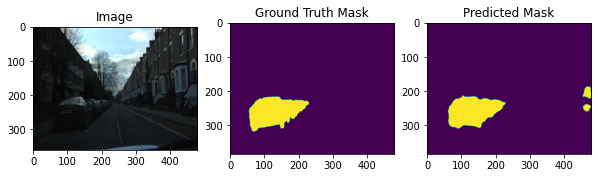

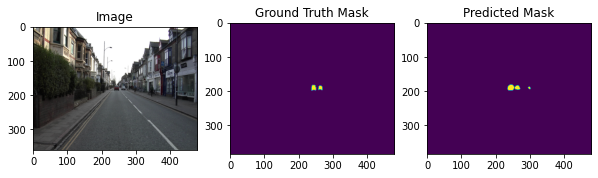

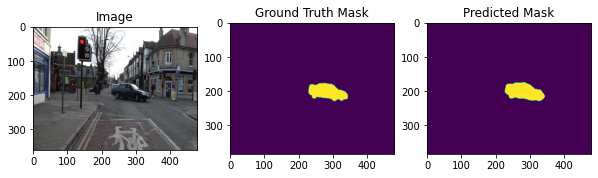

In [36]:
for i in range(3):
  n = np.random.choice(len(test_dataset))
  image_vis = test_dataset_vis[n][0].astype('uint8')
  image, real_mask = test_dataset[n]
  real_mask = real_mask.squeeze()

  x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)

  predict_mask = best_model.predict(x_tensor)
  predict_mask = predict_mask.squeeze().cpu().numpy().round()

  visualize(
      image = image_vis,
      ground_truth_mask = real_mask,
      predicted_mask = predict_mask,
  )